# Data Mining Project
This notebook demonstrates the data preprocessing and analysis steps for the Bike Rentals dataset in San Jose. The goal is to clean the data, extract relevant features, and perform exploratory data analysis to derive insights.

## Step 1: Data Preprocessing with Spark
In this step I load, clean and merge datasets using Spark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, to_date, date_format, when, count, desc, round, lit, sum, dayofweek, unix_timestamp, avg, hour, floor, expr #ultimo non serve, avg, expr
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("BikeShare Data Preprocessing").getOrCreate()

### Step 1.1: Load datasets

In [2]:
trip_data = spark.read.csv(r"C:\Users\utente\Desktop\UNITN\data mining\Project\data bike rentals san jose\trip_data.csv", header=True, inferSchema=True)
station_data = spark.read.csv(r"C:\Users\utente\Desktop\UNITN\data mining\Project\data bike rentals san jose\station_data.csv", header=True, inferSchema=True)
weather_data = spark.read.csv(r"C:\Users\utente\Desktop\UNITN\data mining\Project\data bike rentals san jose\weather_data.csv", header=True, inferSchema=True)

### Step 1.2: Preparation of datasets
##### TRIP DATA:
We process the `Start Date` and `End Date` columns to extract:
- **Start_date**: The date when the trip started.
- **Start_time**: The time when the trip started.
- **End_date**: The date when the trip ended.
- **End_time**: The time when the trip ended.

The original `Start Date` and `End Date` columns are dropped after extraction.

In [3]:
# Convert "Start Date" and "End Date" to timestamp 
trip_data = trip_data.withColumn("Start Date", to_timestamp(col("Start Date"), "dd/MM/yyyy HH:mm")) \
                     .withColumn("End Date", to_timestamp(col("End Date"), "dd/MM/yyyy HH:mm"))

# Extract Start_date and Start_time
trip_data = trip_data.withColumn("Start_date", to_date(col("Start Date"))) \
                     .withColumn("Start_time", date_format(col("Start Date"), "HH:mm:ss"))

# Extract End_date and End_time
trip_data = trip_data.withColumn("End_date", to_date(col("End Date"))) \
                     .withColumn("End_time", date_format(col("End Date"), "HH:mm:ss"))

trip_data = trip_data.drop("Start Date", "End Date")

##### WEATHER DATA: Convert the `Date` column to date type

In [4]:
weather_data = weather_data.withColumn("Date", to_date(col("Date"), "dd/MM/yyyy"))

##### STATION DATA: Define the city-to-zip mapping and replace the `City` column with mapped Zip codes

In [9]:
city_to_zip = {
    "San Francisco": "94107",
    "Redwood City": "94063",
    "Palo Alto": "94301",
    "Mountain View": "94041",
    "San Jose": "95113"
}

# Start with the existing DataFrame
station_data_updated = station_data

# Replace city values with zip codes
for city, zip_code in city_to_zip.items():
    station_data_updated = station_data_updated.withColumn(
        "city",
        when(col("city") == city, zip_code).otherwise(col("city"))
    )

### Step 1.3: Merge datasets using SQL queries

In [6]:
# Register dataframes as temporary SQL views
trip_data.createOrReplaceTempView("trip")
weather_data.createOrReplaceTempView("weather")
station_data_updated.createOrReplaceTempView("station") 

In [ ]:
# Dimension of the datasets
print(f"Trip data rows: {trip_data.count()}")
print(f"Weather data rows: {weather_data.count()}")
print(f"Station data rows: {station_data_updated.count()}")

Trip data rows: 354152
Weather data rows: 1825
Station data rows: 76


In [17]:
final_data = spark.sql("""
    SELECT DISTINCT
        -- Trip details
        t.`Trip ID`, t.`Start Station`, t.`End Station`, t.`Subscriber Type`, t.`Start_date`, 
        t.`End_date`, t.`Start_time`, t.`End_time`, 
        
        -- Weather details
        w.`Max TemperatureF`, w.`Mean TemperatureF`, w.`Min TemperatureF`, w.`Max Dew PointF`,     
        w.`MeanDew PointF`, w.`Min DewpointF`, w.`Max Humidity`, w.`Mean Humidity`,     
        w.`Min Humidity`, w.`Max Sea Level PressureIn`, w.`Mean Sea Level PressureIn`, 
        w.`Min Sea Level PressureIn`, w.`Max VisibilityMiles`, w.`Mean VisibilityMiles`, 
        w.`Min VisibilityMiles`, w.`Max Wind SpeedMPH`, w.`Mean Wind SpeedMPH`, w.`Max Gust SpeedMPH`,
        w.`PrecipitationIn`, w.`CloudCover`, w.`WindDirDegrees`, w.`Events`, w.`Zip`,
                       
        -- Station details
        s1.Name AS Start_Station_Name, s1.City AS Start_Station_City, s1.Lat AS Start_Lat,
        s1.Long AS Start_Long, s1.`Dock Count` AS Start_dock_count,
        s2.Name AS End_Station_Name, s2.City AS End_Station_City, s2.Lat AS End_Lat,
        s2.Long AS End_Long, s2.`Dock Count` AS End_dock_count
    FROM 
        trip t
    INNER JOIN station s1 ON t.`Start Station` = s1.Id
    INNER JOIN station s2 ON t.`End Station` = s2.Id
    INNER JOIN weather w 
        ON t.Start_date = w.Date AND s1.City = w.`Zip`
"""
)

# Show the final merged data
final_data.show(5)

+-------+-------------+-----------+---------------+----------+----------+----------+--------+----------------+-----------------+----------------+--------------+--------------+-------------+------------+-------------+------------+------------------------+-------------------------+------------------------+-------------------+--------------------+-------------------+-----------------+------------------+-----------------+---------------+----------+--------------+-----------------+-----+--------------------+------------------+---------+-----------+----------------+------------------+----------------+---------+-----------+--------------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|  End_date|Start_time|End_time|Max TemperatureF|Mean TemperatureF|Min TemperatureF|Max Dew PointF|MeanDew PointF|Min DewpointF|Max Humidity|Mean Humidity|Min Humidity|Max Sea Level PressureIn|Mean Sea Level PressureIn|Min Sea Level PressureIn|Max VisibilityMiles|Mean VisibilityMiles|Min Visibility

In [18]:
# List of columns to drop
columns_to_drop = ['Events', 'Max Dew PointF', 'Mean Wind SpeedMPH','MeanDew PointF', 'WindDirDegrees', 'Min DewpointF', 'Max Gust SpeedMPH', 'Max Humidity', 'Mean Humidity', 'Min Humidity', 'Max VisibilityMiles', 'Mean VisibilityMiles', 'Min VisibilityMiles']

# Drop the columns
final_data = final_data.drop(*columns_to_drop)

actually better to directly not include those columns in the sql select

### Step 1.4: Preprocessing of final_data

#### Step 1.4.1:
Weather-related measurements are converted to standard units for consistency:

- Temperature: Fahrenheit (°F) → Celsius (°C)
- Precipitation: Inches → Millimeters (mm)
- Wind Speed: Miles per hour (MPH) → Kilometers per hour (km/h)
- Sea Level Pressure: Inches of mercury (inHg) → Millimeters of mercury (mmHg)

Column names are updated for clarity, and the modified dataset is displayed for verification.

In [19]:
# Conversion factors
MILES_TO_KM = 1.60934  # Conversion factor for miles to kilometers
INCHES_TO_MM = 25.4    # Conversion factor for inches to millimeters

# Convert temperature columns (F to C)
temperature_columns = ['Max TemperatureF', 'Mean TemperatureF', 'Min TemperatureF']
for col_name in temperature_columns:
    if col_name in final_data.columns:
        final_data = final_data.withColumn(
            col_name,
            ((col(col_name) - 32) * 5 / 9).cast("double")
        )

# Convert precipitation column (inches to mm)
precipitation_column = 'PrecipitationIn'
if precipitation_column in final_data.columns:
    final_data = final_data.withColumn(
        precipitation_column,
        (col(precipitation_column) * INCHES_TO_MM).cast("double")
    )

# Convert speed column (MPH to km/h)
speed_column = 'Max Wind SpeedMPH'
if speed_column in final_data.columns:
    final_data = final_data.withColumn(
        speed_column,
        (col(speed_column) * MILES_TO_KM).cast("double")
    )

# Convert sea level pressure columns (inHg to mmHg)
sea_level_pressure_columns = ['Max Sea Level PressureIn', 'Mean Sea Level PressureIn', 'Min Sea Level PressureIn']
for col_name in sea_level_pressure_columns:
    if col_name in final_data.columns:
        final_data = final_data.withColumn(
            col_name,
            (col(col_name) * INCHES_TO_MM).cast("double")
        )

# Rename columns to clean up the names (removing F, In, Miles, MPH, and adding appropriate units)
rename_columns = {
    'Max TemperatureF': 'Max Temperature (C)',
    'Mean TemperatureF': 'Mean Temperature (C)',
    'Min TemperatureF': 'Min Temperature (C)',
    'PrecipitationIn': 'Precipitation (mm)',
    'Max Wind SpeedMPH': 'Max Wind Speed (km/h)',
    'Max Sea Level PressureIn': 'Max Sea Level Pressure (mmHg)',
    'Mean Sea Level PressureIn': 'Mean Sea Level Pressure (mmHg)',
    'Min Sea Level PressureIn': 'Min Sea Level Pressure (mmHg)'
}

for old_name, new_name in rename_columns.items():
    if old_name in final_data.columns:
        final_data = final_data.withColumnRenamed(old_name, new_name)

# Show updated dataset for verification
final_data.show(3)

+-------+-------------+-----------+---------------+----------+----------+----------+--------+-------------------+--------------------+-------------------+-----------------------------+------------------------------+-----------------------------+---------------------+------------------+----------+-----+--------------------+------------------+---------+-----------+----------------+------------------+----------------+---------+-----------+--------------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|  End_date|Start_time|End_time|Max Temperature (C)|Mean Temperature (C)|Min Temperature (C)|Max Sea Level Pressure (mmHg)|Mean Sea Level Pressure (mmHg)|Min Sea Level Pressure (mmHg)|Max Wind Speed (km/h)|Precipitation (mm)|CloudCover|  Zip|  Start_Station_Name|Start_Station_City|Start_Lat| Start_Long|Start_dock_count|  End_Station_Name|End_Station_City|  End_Lat|   End_Long|End_dock_count|
+-------+-------------+-----------+---------------+----------+----------+----------+----

#### Step 1.4.2:

Precipitation levels are classified into four categories based on rainfall intensity:

- No Rain: ≤ 0.1 mm
- Light Rain: 0.1 mm – 10 mm
- Moderate Rain: 10 mm – 50 mm
- Heavy Rain: > 50 mm

A new column, `Rainfall Category`, is added to the dataset for easier analysis of weather conditions. 

In [20]:
# Categorize precipitation into 4 levels
final_data = final_data.withColumn(
    "Rainfall Category",
    when(col("Precipitation (mm)") <= 0.1, "No Rain")
    .when((col("Precipitation (mm)") > 0.1) & (col("Precipitation (mm)") <= 10), "Light Rain")
    .when((col("Precipitation (mm)") > 10) & (col("Precipitation (mm)") <= 50), "Moderate Rain")
    .when(col("Precipitation (mm)") > 50, "Heavy Rain")
    .otherwise("Unknown")  # For unexpected or null values
)

# Show dataset with the new category column
final_data.show(3)

+-------+-------------+-----------+---------------+----------+----------+----------+--------+-------------------+--------------------+-------------------+-----------------------------+------------------------------+-----------------------------+---------------------+------------------+----------+-----+--------------------+------------------+---------+-----------+----------------+------------------+----------------+---------+-----------+--------------+-----------------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|  End_date|Start_time|End_time|Max Temperature (C)|Mean Temperature (C)|Min Temperature (C)|Max Sea Level Pressure (mmHg)|Mean Sea Level Pressure (mmHg)|Min Sea Level Pressure (mmHg)|Max Wind Speed (km/h)|Precipitation (mm)|CloudCover|  Zip|  Start_Station_Name|Start_Station_City|Start_Lat| Start_Long|Start_dock_count|  End_Station_Name|End_Station_City|  End_Lat|   End_Long|End_dock_count|Rainfall Category|
+-------+-------------+-----------+---------------+-

### Step 1.4: Inspect missing values

In [21]:
# Count missing values for all columns
missing_values = final_data.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in final_data.columns]
)

# Show the count of missing values for each column
missing_values.show()

+-------+-------------+-----------+---------------+----------+--------+----------+--------+-------------------+--------------------+-------------------+-----------------------------+------------------------------+-----------------------------+---------------------+------------------+----------+---+------------------+------------------+---------+----------+----------------+----------------+----------------+-------+--------+--------------+-----------------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|End_date|Start_time|End_time|Max Temperature (C)|Mean Temperature (C)|Min Temperature (C)|Max Sea Level Pressure (mmHg)|Mean Sea Level Pressure (mmHg)|Min Sea Level Pressure (mmHg)|Max Wind Speed (km/h)|Precipitation (mm)|CloudCover|Zip|Start_Station_Name|Start_Station_City|Start_Lat|Start_Long|Start_dock_count|End_Station_Name|End_Station_City|End_Lat|End_Long|End_dock_count|Rainfall Category|
+-------+-------------+-----------+---------------+----------+--------+---------

*Identifying Missing Weather Data by Date*

To analyze patterns in missing weather data, all rows with null values in key weather-related columns are filtered. The missing entries are then grouped by Start_date, and their occurrences are counted to determine whether data gaps are concentrated on specific days. 

In [22]:
# Filter rows with missing weather data
missing_weather_rows = final_data.filter(
    (col("Max Temperature (C)").isNull()) |
    (col("Mean Temperature (C)").isNull())|
    (col("Min Temperature (C)").isNull())|
    (col("Max Sea Level Pressure (mmHg)").isNull())|
    (col("Min Sea Level Pressure (mmHg)").isNull())|
    (col("Mean Sea Level Pressure (mmHg)").isNull())|
    (col("Max Wind Speed (km/h)").isNull())|
    (col("Precipitation (mm)").isNull())|
    (col("CloudCover").isNull())
)

missing_weather_rows.groupBy("Start_date").count().orderBy(desc("count")).show()

+----------+-----+
|Start_date|count|
+----------+-----+
|2015-05-01|   33|
|2015-08-08|   14|
|2015-05-03|   11|
|2015-05-02|    8|
+----------+-----+



The output reveals that missing weather data is not randomly distributed but occurs on specific dates, with May 1, 2015, having the highest number of missing entries (33 records). This suggests possible data collection issues or gaps in the weather dataset for those days.

#### Step 1.4.1: Imputation of missing values

In [23]:
from pyspark.sql.functions import col, abs, lit, array, explode, when
import networkx as nx
from itertools import combinations
import numpy as np
from datetime import timedelta
from pyspark.sql import DataFrame

# Step 1: Compute Pairwise Distances

# The Haversine formula calculates distances between cities based on latitude and longitude.

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Extract unique locations
locations = final_data.select("Start_Station_City", "Start_Lat", "Start_Long").distinct().collect()

# An inverse distance weighting function assigns higher importance to closer locations.
distance_lookup = {}
computed_pairs = set()
for loc1, loc2 in combinations(locations, 2):
    city1, lat1, lon1 = loc1["Start_Station_City"], loc1["Start_Lat"], loc1["Start_Long"]
    city2, lat2, lon2 = loc2["Start_Station_City"], loc2["Start_Lat"], loc2["Start_Long"]
    pair = tuple(sorted([city1, city2]))
    if city1 != city2 and pair not in computed_pairs:  # Avoid self-distances and duplicate computations
        dist = haversine(lat1, lon1, lat2, lon2)
        distance_lookup[pair] = 1 / (1 + dist)  # Inverse function for weighting
        computed_pairs.add(pair)

# Step 2: Identify Rows with Missing Values
variables_to_impute = [
    "Mean Temperature (C)", "Max Temperature (C)", "Min Temperature (C)",
    "Max Sea Level Pressure (mmHg)", "Mean Sea Level Pressure (mmHg)", "Min Sea Level Pressure (mmHg)",
    "Max Wind Speed (km/h)", 
    "Precipitation (mm)", "CloudCover"
]

# Step 3: Graph Construction and Imputation

# Spatial neighbors (same date, different city) are identified for each missing value.
# A graph is built using NetworkX, where edges are weighted based on precomputed distances.
# Missing values are estimated using a weighted average of neighboring values.
# Cached values prevent redundant computations, and the dataset is dynamically updated with imputed values.

def impute_missing_values(final_data: DataFrame, variable: str) -> DataFrame:
    missing_rows = final_data.filter(col(variable).isNull())
    imputed_values_cache = {}
    for first_missing_row in missing_rows.collect():
        row_id = first_missing_row["Trip ID"]
        row_date = first_missing_row["Start_date"]
        row_city = first_missing_row["Start_Station_City"]
        cache_key = (row_date, row_city)
        
        # Check if this value has already been imputed for the same date and location
        if cache_key in imputed_values_cache:
            imputed_value = imputed_values_cache[cache_key]
            print(f"Using cached imputed value for {variable} on {row_date} at {row_city}: {imputed_value}")
        else:
            # Find unique spatial neighbors
            spatial_neighbors_df = final_data.filter(
                (col("Start_date") == row_date) & 
                (col("Start_Station_City") != row_city)
            ).dropDuplicates([variable])
            
            # Print the number of rows in spatial_neighbors_df
            print(f"Variable: {variable} - Total spatial neighbors: {spatial_neighbors_df.count()}")
            
            spatial_neighbors = spatial_neighbors_df.collect()

            # Build graph
            G = nx.Graph()
            for neighbor in spatial_neighbors:
                neighbor_id = neighbor["Trip ID"]
                neighbor_city = neighbor["Start_Station_City"]
                city_pair = tuple(sorted([row_city, neighbor_city]))
                distance_weight = distance_lookup.get(city_pair, 0)
                if distance_weight > 0:
                    G.add_edge(row_id, neighbor_id, weight=distance_weight)

            # Perform imputation
            neighbors = list(G.neighbors(row_id))
            weights = []
            values = []
            for neighbor_id in neighbors:
                neighbor_data = next((n for n in spatial_neighbors if n["Trip ID"] == neighbor_id), None)
                if neighbor_data and neighbor_data[variable] is not None:
                    edge_weight = G[row_id][neighbor_id]["weight"]
                    weights.append(edge_weight)
                    values.append(neighbor_data[variable] * edge_weight)
            
            imputed_value = np.sum(values) / np.sum(weights) if weights else None
            print(f"\nImputed {variable} for Trip ID {row_id}: {imputed_value}")
            
            # Cache the imputed value
            imputed_values_cache[cache_key] = imputed_value

        # Update DataFrame
        final_data = final_data.withColumn(
            variable,
            when(col("Trip ID") == row_id, lit(imputed_value)).otherwise(col(variable))
        )
    
    return final_data

# Perform imputation for all selected variables
for variable in variables_to_impute:
    final_data = impute_missing_values(final_data, variable)

print("\nUpdated DataFrame with Imputed Values:")
final_data.show()


Variable: Mean Temperature (C) - Total spatial neighbors: 2

Imputed Mean Temperature (C) for Trip ID 881675: 19.97055577029454
Using cached imputed value for Mean Temperature (C) on 2015-08-08 at 94301: 19.97055577029454
Using cached imputed value for Mean Temperature (C) on 2015-08-08 at 94301: 19.97055577029454
Using cached imputed value for Mean Temperature (C) on 2015-08-08 at 94301: 19.97055577029454
Using cached imputed value for Mean Temperature (C) on 2015-08-08 at 94301: 19.97055577029454
Using cached imputed value for Mean Temperature (C) on 2015-08-08 at 94301: 19.97055577029454
Using cached imputed value for Mean Temperature (C) on 2015-08-08 at 94301: 19.97055577029454
Using cached imputed value for Mean Temperature (C) on 2015-08-08 at 94301: 19.97055577029454
Using cached imputed value for Mean Temperature (C) on 2015-08-08 at 94301: 19.97055577029454
Using cached imputed value for Mean Temperature (C) on 2015-08-08 at 94301: 19.97055577029454
Using cached imputed value

In [24]:
# Count missing values for all columns
missing_values = final_data.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in final_data.columns]
)

# Show the count of missing values for each column
missing_values.show()

+-------+-------------+-----------+---------------+----------+--------+----------+--------+-------------------+--------------------+-------------------+-----------------------------+------------------------------+-----------------------------+---------------------+------------------+----------+---+------------------+------------------+---------+----------+----------------+----------------+----------------+-------+--------+--------------+-----------------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|End_date|Start_time|End_time|Max Temperature (C)|Mean Temperature (C)|Min Temperature (C)|Max Sea Level Pressure (mmHg)|Mean Sea Level Pressure (mmHg)|Min Sea Level Pressure (mmHg)|Max Wind Speed (km/h)|Precipitation (mm)|CloudCover|Zip|Start_Station_Name|Start_Station_City|Start_Lat|Start_Long|Start_dock_count|End_Station_Name|End_Station_City|End_Lat|End_Long|End_dock_count|Rainfall Category|
+-------+-------------+-----------+---------------+----------+--------+---------

I could have done imputation also taking into consideration close days, not only close locations. but i prefered the first option

# 2. DATA EXPLORATION

## Step 2.1: Implement MapReduce for different tasks
- Identify the stations with the highest combined activity (pickups and returns)

In [25]:
# 1. Map Phase: Create key-value pairs for pickups and returns
pickups = final_data.select(
    col("Start Station").alias("Station")
).withColumn("Pickups", lit(1)).withColumn("Returns", lit(0))

returns = final_data.select(
    col("End Station").alias("Station")
).withColumn("Returns", lit(1)).withColumn("Pickups", lit(0))

# 2. Shuffle Phase: Combine all records by station
# Ensure both DataFrames have the same schema
combined = pickups.unionByName(returns)

# 3. Reduce Phase: Aggregate counts for pickups and returns
station_activity = combined.groupBy("Station").agg(
    sum("Pickups").alias("Pickups"),
    sum("Returns").alias("Returns")
)

# 4. Add Total Activity Column
station_activity = station_activity.withColumn(
    "Total Activity", col("Pickups") + col("Returns")
)

# 5. Sort by Total Activity in Descending Order
busiest_stations = station_activity.orderBy(col("Total Activity").desc())

# Show the results
busiest_stations.show(5)

+-------+-------+-------+--------------+
|Station|Pickups|Returns|Total Activity|
+-------+-------+-------+--------------+
|     70|  26304|  34810|         61114|
|     50|  17255|  17810|         35065|
|     61|  14026|  15463|         29489|
|     60|  14158|  15065|         29223|
|     65|  13752|  15422|         29174|
+-------+-------+-------+--------------+
only showing top 5 rows



The top 5 busiest stations are 70, 50, 61, 60, 65

- IDENTIFY THE MOST POPULAR ROUTES:
Instead of looking at stations individually, analyze the most frequently traveled routes (Start Station → End Station) to understand the most commonly used paths

In [26]:
# 1. Map Phase: Create key-value pairs for routes
routes = final_data.select(col("Start Station"), col("End Station")).withColumn("Count", lit(1))

# 2. Shuffle and Reduce Phase: Group by route and sum counts
route_counts = routes.groupBy("Start Station", "End Station").agg(sum("Count").alias("Trip Count"))

# 3. Sort by Trip Count in descending order
popular_routes = route_counts.orderBy(col("Trip Count").desc())

popular_routes.show(5)

+-------------+-----------+----------+
|Start Station|End Station|Trip Count|
+-------------+-----------+----------+
|           50|         60|      3145|
|           61|         50|      2973|
|           50|         61|      2640|
|           51|         70|      2439|
|           74|         61|      2356|
+-------------+-----------+----------+
only showing top 5 rows



The top 5 busiest stations are 70, 50, 61, 60, 65. Intuitlively the most common routes are the one between those stations

- TRIPS BY WEEK DAY: Analyze how trip volume varies by the day of the week.

In [89]:
# Add a column for the weekday number (1 = Sunday, ..., 7 = Saturday)
final_data = final_data.withColumn("Start_weekday_num", dayofweek(col("Start_date")))

# Remap weekday numbers so Monday = 1, Sunday = 7
final_data = final_data.withColumn(
    "Start_weekday_mapped",
    when(col("Start_weekday_num") == 2, 1)  # Monday
    .when(col("Start_weekday_num") == 3, 2)  # Tuesday
    .when(col("Start_weekday_num") == 4, 3)  # Wednesday
    .when(col("Start_weekday_num") == 5, 4)  # Thursday
    .when(col("Start_weekday_num") == 6, 5)  # Friday
    .when(col("Start_weekday_num") == 7, 6)  # Saturday
    .when(col("Start_weekday_num") == 1, 7)  # Sunday
)

# Map the new weekday numbers to their names
final_data = final_data.withColumn(
    "Start_weekday",
    when(col("Start_weekday_mapped") == 1, "Monday")
    .when(col("Start_weekday_mapped") == 2, "Tuesday")
    .when(col("Start_weekday_mapped") == 3, "Wednesday")
    .when(col("Start_weekday_mapped") == 4, "Thursday")
    .when(col("Start_weekday_mapped") == 5, "Friday")
    .when(col("Start_weekday_mapped") == 6, "Saturday")
    .when(col("Start_weekday_mapped") == 7, "Sunday")
)

# Group by the new weekday column and include mapped values
trips_by_weekday = final_data.groupBy("Start_weekday", "Start_weekday_mapped").count().withColumnRenamed("count", "Total Trips")

# Sort by Start_weekday_mapped to ensure Monday is first
trips_by_weekday = trips_by_weekday.orderBy("Start_weekday_mapped")

trips_by_weekday.show()


+-------------+--------------------+-----------+
|Start_weekday|Start_weekday_mapped|Total Trips|
+-------------+--------------------+-----------+
|       Monday|                   1|      63718|
|      Tuesday|                   2|      66503|
|    Wednesday|                   3|      65285|
|     Thursday|                   4|      63184|
|       Friday|                   5|      57808|
|     Saturday|                   6|      20935|
|       Sunday|                   7|      16719|
+-------------+--------------------+-----------+



- AVERAGE TRIP DURATION BY STATION

In [26]:
# 1. Map Phase: Calculate Trip Duration and Create Key-Value Pairs
mapped_start = final_data.withColumn("Trip_Duration", 
    (unix_timestamp(col("End_time")) - unix_timestamp(col("Start_time"))) / 60
).select(
    col("Start Station").alias("Station"),
    col("Trip_Duration"),
    lit("Start").alias("Station Type")
)

mapped_end = final_data.withColumn("Trip_Duration", 
    (unix_timestamp(col("End_time")) - unix_timestamp(col("Start_time"))) / 60
).select(
    col("End Station").alias("Station"),
    col("Trip_Duration"),
    lit("End").alias("Station Type")
)

# 2. Shuffle Phase: Combine Start and End Station Data
combined_data = mapped_start.union(mapped_end)

# 3. Reduce Phase: Aggregate to Calculate Averages
avg_trip_duration_combined = combined_data.groupBy("Station", "Station Type").agg(
    (sum("Trip_Duration") / count("Trip_Duration")).alias("Avg Trip Duration (mins)")
)

# 4. Sort Phase: Sort by Average Trip Duration
avg_trip_duration_combined = avg_trip_duration_combined.orderBy(col("Avg Trip Duration (mins)").desc())

avg_trip_duration_combined.show(5)


+-------+------------+------------------------+
|Station|Station Type|Avg Trip Duration (mins)|
+-------+------------+------------------------+
|     35|         End|      50.693370165745854|
|     25|       Start|      50.111111111111114|
|     35|       Start|      41.337190082644625|
|     83|         End|      30.517241379310345|
|     36|         End|      30.401209677419356|
+-------+------------+------------------------+
only showing top 5 rows



- Analyse how behaviours change between subscriber type

In [27]:
total_trips = final_data.count()

# Group by Subscriber Type and count trips
trips_by_user_type = final_data.groupBy("Subscriber Type").count().withColumnRenamed("count", "Total Trips")

# Add a percentage column to show the proportion of trips for each user type
trips_by_user_type = trips_by_user_type.withColumn(
    "Percentage of total trips",
    round((col("Total Trips") / total_trips) * 100, 2)
)

# Step 2: Calculate Average Trip Duration by Subscriber Type
avg_trip_duration_by_user_type = final_data.groupBy("Subscriber Type").agg(
    avg("Trip_Duration").alias("Avg Trip Duration (mins)")
).withColumn(
    "Avg Trip Duration (mins)", round(col("Avg Trip Duration (mins)"), 2)
)

# Step 3: Calculate Average Temperature by Subscriber Type
avg_temperature_by_user_type = final_data.groupBy("Subscriber Type").agg(
    avg(col("Mean Temperature (C)")).alias("Avg Temperature (C)")
).withColumn(
    "Avg Temperature (C)", round(col("Avg Temperature (C)"), 2)
)

# Step 4: Combine All Results
result = trips_by_user_type \
    .join(avg_trip_duration_by_user_type, on="Subscriber Type", how="inner") \
    .join(avg_temperature_by_user_type, on="Subscriber Type", how="inner")


print("Total Trips, Average Trip Duration, and Average Temperature by Subscriber Type:")
result.show()

Total Trips, Average Trip Duration, and Average Temperature by Subscriber Type:
+---------------+-----------+-------------------------+------------------------+-------------------+
|Subscriber Type|Total Trips|Percentage of total trips|Avg Trip Duration (mins)|Avg Temperature (C)|
+---------------+-----------+-------------------------+------------------------+-------------------+
|     Subscriber|     310217|                    87.59|                    8.11|              16.15|
|       Customer|      43935|                    12.41|                   38.54|              16.65|
+---------------+-----------+-------------------------+------------------------+-------------------+



- frequency of bike rentals by subscriber type for each hour of the day

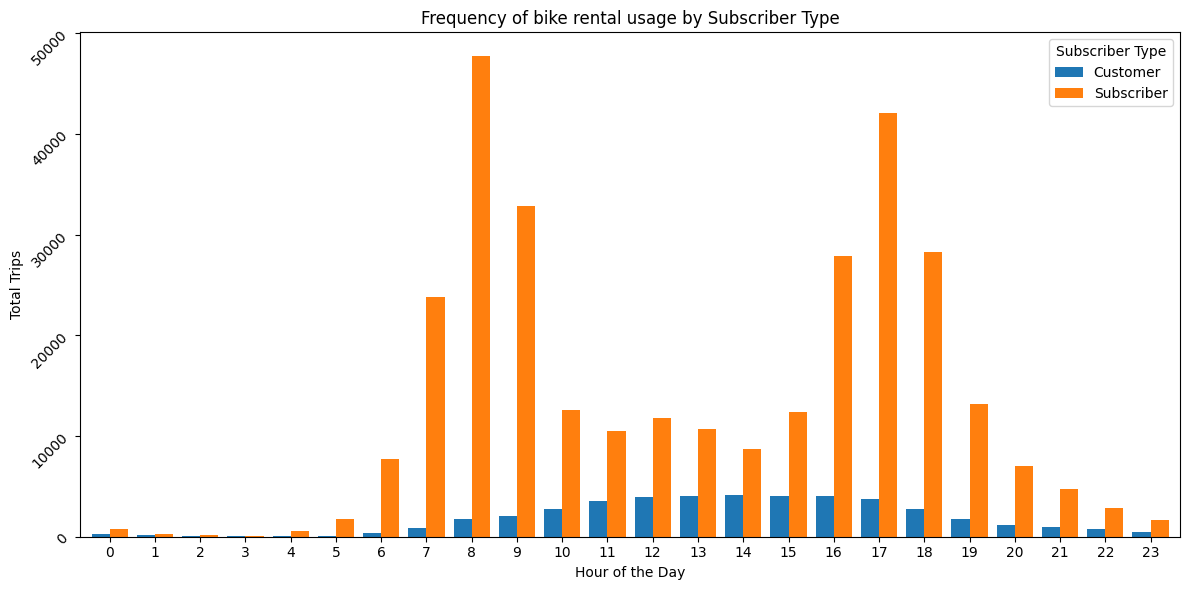

In [27]:
# Extract hour from Start_time
final_data = final_data.withColumn("Start_hour", hour(col("Start_time")))

# Group by Subscriber Type and Start_hour
peak_hours_by_user_type = final_data.groupBy("Subscriber Type", "Start_hour").count().withColumnRenamed("count", "Total Trips")

# Convert the PySpark DataFrame to a Pandas DataFrame
peak_hours_df = peak_hours_by_user_type.toPandas()

# Pivot the data for visualization
pivot_table = peak_hours_df.pivot(index="Start_hour", columns="Subscriber Type", values="Total Trips").fillna(0)

# Plot a histogram
pivot_table.plot(kind="bar", figsize=(12, 6), width=0.8)

# Customize the plot
plt.title("Frequency of bike rental usage by Subscriber Type")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Trips")
plt.xticks(rotation=0)
plt.yticks(rotation=45)
plt.legend(title="Subscriber Type")
plt.tight_layout()

plt.show()


*Average daily trips by temperature bin*

To analyze the relationship between temperature and bike usage, trips are grouped into temperature bins (rounded down). Instead of total trip counts, the average number of trips per day is calculated for each bin to ensure a fair comparison. The results are visualized in a bar chart.

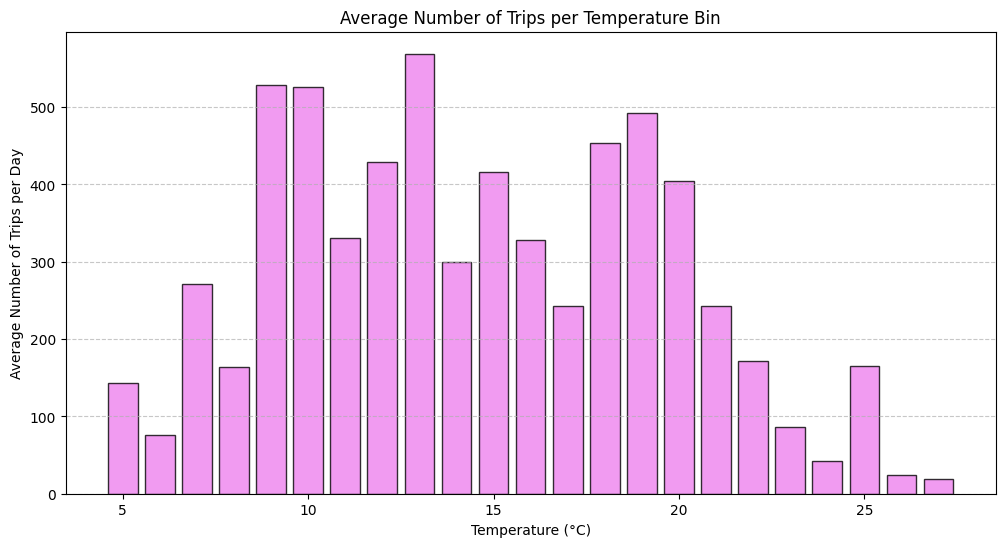

In [28]:
from pyspark.sql.functions import count, floor, avg, round

# Step 1: Bin temperatures
final_data = final_data.withColumn(
    "Temperature Bin", floor(col("Mean Temperature (C)"))
)

# Step 2: Calculate the average number of trips per temperature bin
trips_by_temperature = final_data.groupBy("Temperature Bin", "Start_date").agg(
    count("Trip ID").alias("Daily Trips")
)

# Step 3: Compute the average trips per bin
avg_trips_by_temperature = trips_by_temperature.groupBy("Temperature Bin").agg(
    round(avg("Daily Trips"), 2).alias("Average Trips per Day")
)

# Convert to Pandas for plotting
avg_trips_by_temperature_pandas = avg_trips_by_temperature.toPandas()

# Extract data for plotting
temperature_bins = avg_trips_by_temperature_pandas["Temperature Bin"]
avg_trips = avg_trips_by_temperature_pandas["Average Trips per Day"]

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(temperature_bins, avg_trips, color='violet', edgecolor='black', alpha=0.8)

# Add labels and title
plt.xlabel("Temperature (°C)")
plt.ylabel("Average Number of Trips per Day")
plt.title("Average Number of Trips per Temperature Bin")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 2.2 Explore data with respect to weather

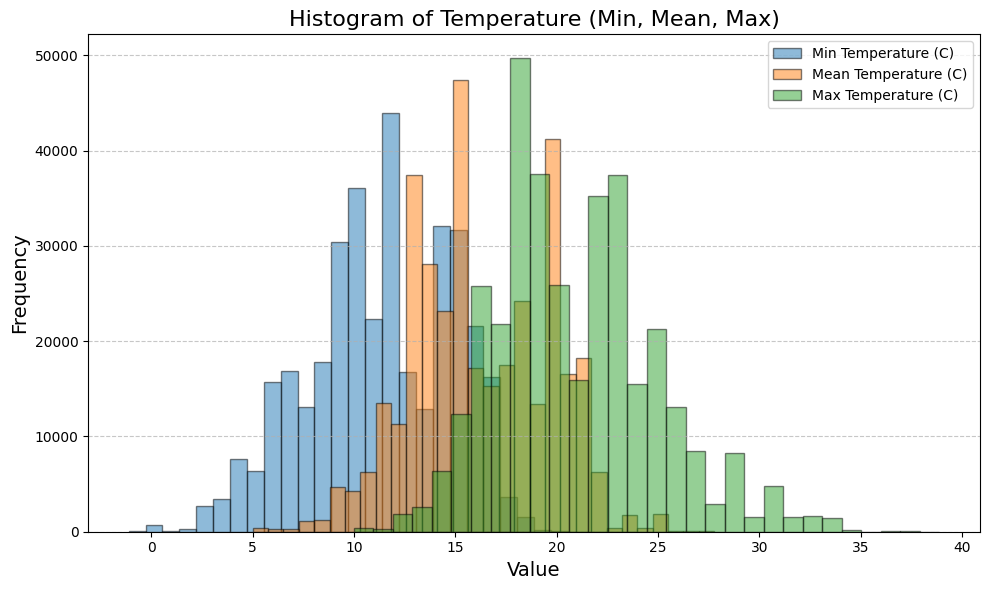

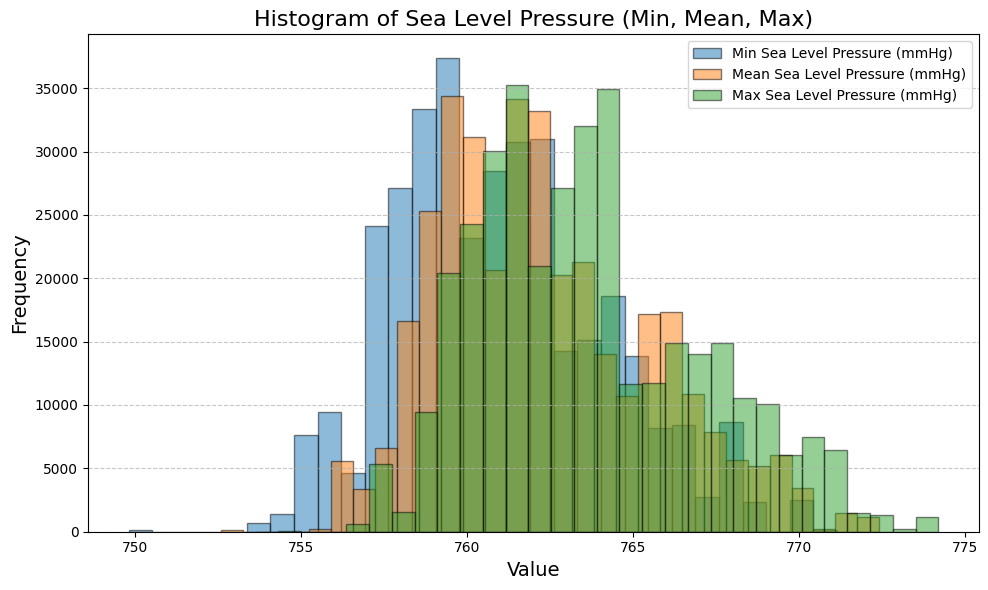

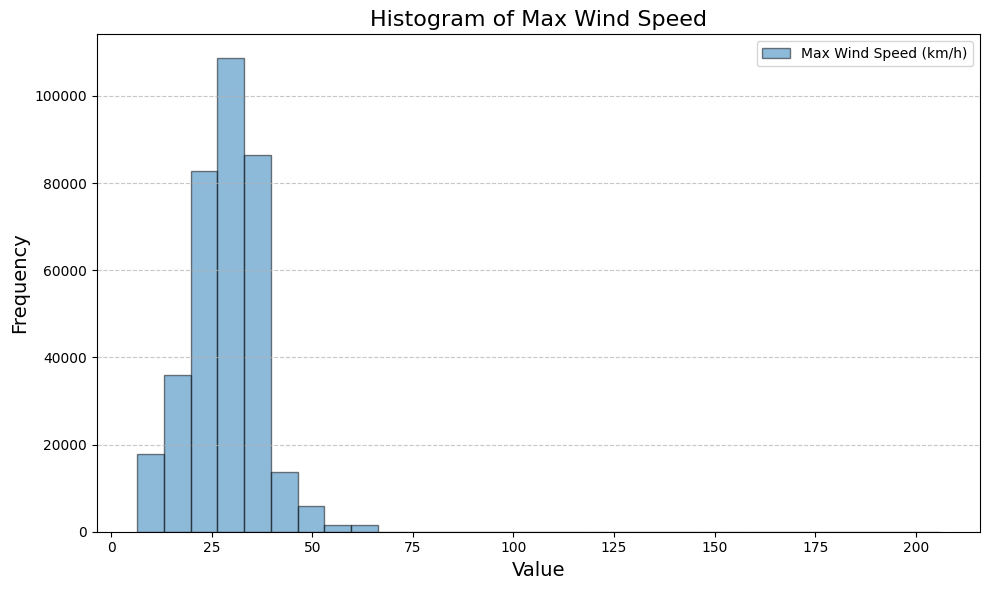

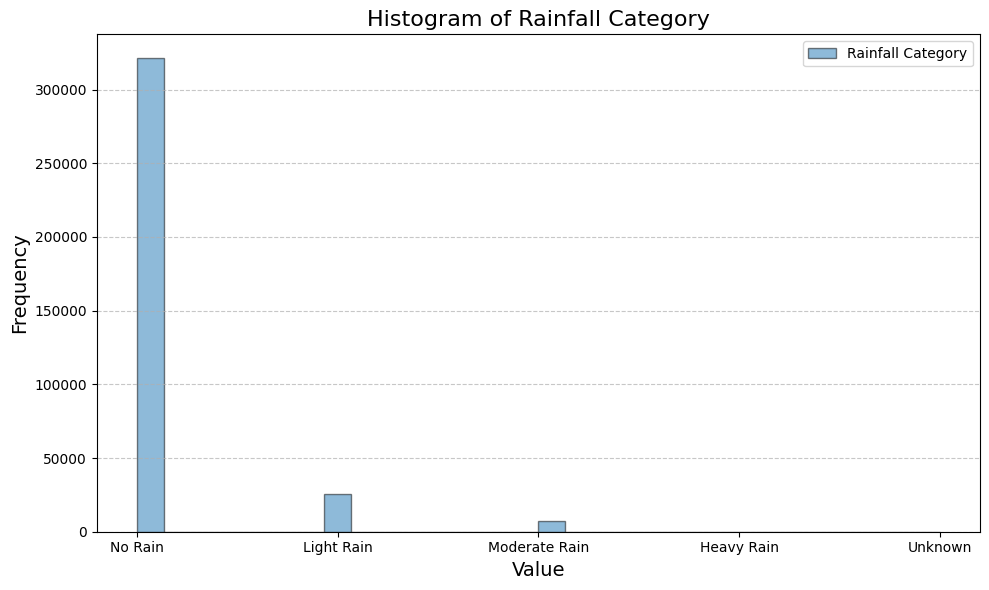

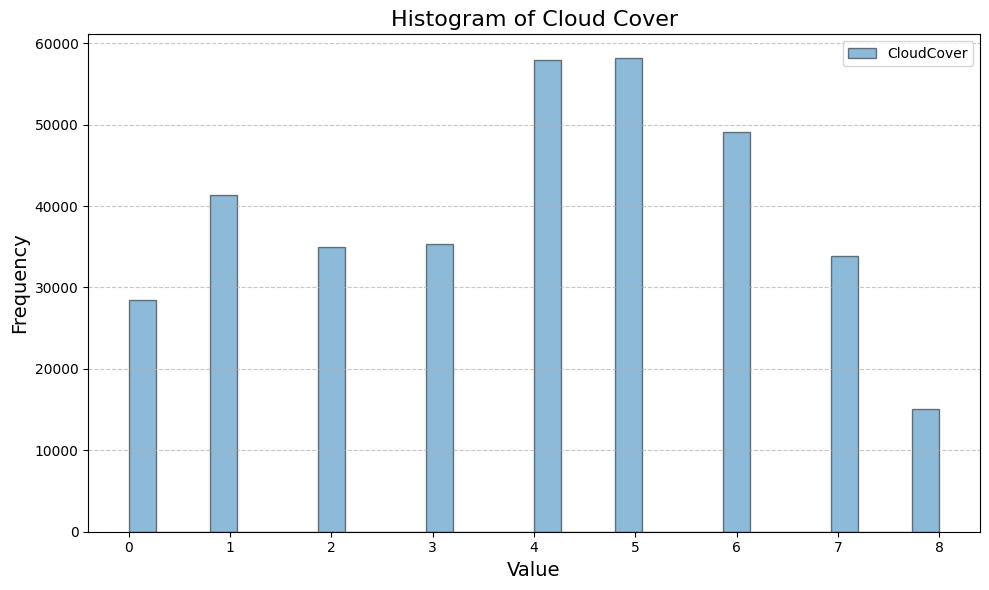

Grouped histograms generated and displayed.


In [29]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import year, month, dayofmonth

# Define groups of related columns (updated names)
temperature_cols = ["Min Temperature (C)", "Mean Temperature (C)", "Max Temperature (C)"]
pressure_cols = ["Min Sea Level Pressure (mmHg)", "Mean Sea Level Pressure (mmHg)", "Max Sea Level Pressure (mmHg)"]
wind_speed_cols = ["Max Wind Speed (km/h)"]
precipitation_col = ["Rainfall Category"]
cloud_cover_col = ["CloudCover"]

# Process temporal columns
# Extract year, month, day, and hour for temporal variables
if "Start_date" in final_data.columns:
    final_data = final_data.withColumn("Start_year", year("Start_date"))
    final_data = final_data.withColumn("Start_month", month("Start_date"))
    final_data = final_data.withColumn("Start_day", dayofmonth("Start_date"))

if "End_date" in final_data.columns:
    final_data = final_data.withColumn("End_year", year("End_date"))
    final_data = final_data.withColumn("End_month", month("End_date"))
    final_data = final_data.withColumn("End_day", dayofmonth("End_date"))

# Function to plot grouped histograms
def plot_grouped_histogram(columns, title):
    plt.figure(figsize=(10, 6))  # Reduced figure size for smaller histograms
    for col in columns:
        try:
            data = final_data.select(col).toPandas()[col].dropna()

            plt.hist(data, bins=30, alpha=0.5, label=col, edgecolor='k')
        except Exception as e:
            print(f"Could not plot column {col}: {e}")
    plt.title(f"Histogram of {title}", fontsize=16)
    plt.xlabel("Value", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend(loc="upper right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot grouped histograms
plot_grouped_histogram(temperature_cols, "Temperature (Min, Mean, Max)")
plot_grouped_histogram(pressure_cols, "Sea Level Pressure (Min, Mean, Max)")
plot_grouped_histogram(wind_speed_cols, "Max Wind Speed")
plot_grouped_histogram(precipitation_col, "Rainfall Category")
plot_grouped_histogram(cloud_cover_col, "Cloud Cover")

print("Grouped histograms generated and displayed.")

*Impact of Rainfall on daily bike usage*

To understand how rainfall affects bike trips, trips are grouped by rainfall category and date. The average number of daily trips is then calculated for each category and sorted in descending order.

In [35]:
# Assuming 'Start_date' is the column representing the trip start date
# Group trips by date and rainfall category
daily_trips = final_data.groupBy("Start_date", "Rainfall Category").agg(
    count("*").alias("Daily Trips")  # Count trips per day
)

# Calculate the average number of daily trips for each rainfall category
average_daily_trips = daily_trips.groupBy("Rainfall Category").agg(
    avg("Daily Trips").alias("Average Daily Trips")
)

# Sort the result by 'Average Daily Trips' in descending order
sorted_average_daily_trips = average_daily_trips.orderBy(col("Average Daily Trips").desc())

# Show the result
sorted_average_daily_trips.show()

+-----------------+-------------------+
|Rainfall Category|Average Daily Trips|
+-----------------+-------------------+
|          No Rain|  882.8956043956044|
|    Moderate Rain|  507.2857142857143|
|       Light Rain| 425.93333333333334|
|       Heavy Rain|              106.0|
|          Unknown|               14.0|
+-----------------+-------------------+



Bike usage is highest on dry days, with an average of ~889 trips per day when there is no rain.

Moderate and light rain significantly reduce ridership, but a notable number of trips still occur.

Heavy rain drastically lowers bike usage, with only ~106 trips per day on average.

The "Unknown" category likely represents data gaps or missing values.

*Average trip duration per Rainfall category*

To examine how rainfall influences trip length, the average trip duration is calculated for each rainfall category and sorted in descending order.

In [36]:
# Calculate the average trip duration for each rainfall category
average_trip_duration = final_data.groupBy("Rainfall Category").agg(
    avg("Trip_duration").alias("Average Trip Duration")
)

# Sort the results by average trip duration in descending order
sorted_average_trip_duration = average_trip_duration.orderBy(col("Average Trip Duration").desc())

# Show the result
sorted_average_trip_duration.show()

+-----------------+---------------------+
|Rainfall Category|Average Trip Duration|
+-----------------+---------------------+
|          Unknown|    78.64285714285714|
|       Heavy Rain|   20.632075471698112|
|          No Rain|   12.043569174855465|
|       Light Rain|   10.989982782908124|
|    Moderate Rain|    7.822021965643481|
+-----------------+---------------------+



Trips in heavy rain tend to last longer (~20.6 min) than in moderate or light rain. This could indicate cautious riding behavior or fewer short-distance casual trips.

Dry conditions lead to shorter average trip durations (~12 min), possibly due to more frequent short rides.

The "Unknown" category shows the longest duration (~78.6 min), likely due to data inconsistencies or outliers.

Moderate rain has the shortest trips (~7.8 min), suggesting riders may avoid prolonged exposure to wet conditions.

In [37]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col, count

# Calculate trip count for each station and rainfall category
station_trip_counts = final_data.groupBy("Start Station", "Rainfall Category").agg(
    count("*").alias("Trip Count")
)

# Define a window partitioned by rainfall category, ordered by trip count (descending)
windowSpec = Window.partitionBy("Rainfall Category").orderBy(col("Trip Count").desc())

# Add a rank column to identify the top stations per category
ranked_stations = station_trip_counts.withColumn(
    "Rank", row_number().over(windowSpec)
)

# Filter to include only the top 5 stations per category
top_5_stations = ranked_stations.filter(col("Rank") <= 5)

# Show the results
top_5_stations.select("Rainfall Category", "Start Station", "Trip Count", "Rank").show()


+-----------------+-------------+----------+----+
|Rainfall Category|Start Station|Trip Count|Rank|
+-----------------+-------------+----------+----+
|       Heavy Rain|           70|        11|   1|
|       Heavy Rain|           69|         6|   2|
|       Heavy Rain|           50|         6|   3|
|       Heavy Rain|           65|         4|   4|
|       Heavy Rain|           55|         4|   5|
|       Light Rain|           70|      2023|   1|
|       Light Rain|           50|      1137|   2|
|       Light Rain|           65|      1037|   3|
|       Light Rain|           60|      1030|   4|
|       Light Rain|           69|       981|   5|
|    Moderate Rain|           70|       688|   1|
|    Moderate Rain|           69|       395|   2|
|    Moderate Rain|           55|       355|   3|
|    Moderate Rain|           65|       335|   4|
|    Moderate Rain|           50|       331|   5|
|          No Rain|           70|     23582|   1|
|          No Rain|           50|     15781|   2|


# 3. Station Importance Ranking Using PageRank

### Step 3.1. Preprocess the Dataset
Let's build the directed graph:

Nodes = unique bike stations.\
Edges = directed trips between stations (weighted by the frequency of trips).

In [38]:
from pyspark.sql import functions as F

# Group by start and end stations to calculate the number of trips (weights)
edge_weights = final_data.groupBy("Start Station", "End Station") \
    .agg(F.count("*").alias("weight"))

# Collect all unique stations (nodes)
nodes = edge_weights.select("Start Station").union(edge_weights.select("End Station")).distinct()

In [39]:
print(edge_weights.show(4))

+-------------+-----------+------+
|Start Station|End Station|weight|
+-------------+-----------+------+
|           65|         50|   827|
|           62|         87|   137|
|           68|         57|   270|
|           64|         48|   169|
+-------------+-----------+------+
only showing top 4 rows

None


#### Step 2.2 Build the Transition Matrix
Represent the trips as a transition matrix. Each element 𝑀𝑖𝑗 in the matrix represents the probability of moving from station 𝑗 to station 𝑖.

1- Calculate the total outgoing trips for each station.

2- Normalize edge weights to get probabilities.

In [40]:
# Calculate total outgoing trips for each station
total_outgoing = edge_weights.groupBy("Start Station") \
    .agg(F.sum("weight").alias("total_weight"))

# Join with edge weights to calculate probabilities
transition_df = edge_weights.join(total_outgoing, on="Start Station") \
    .withColumn("probability", round(F.col("weight") / F.col("total_weight"), 4))

# Transition matrix rows: Start Station, End Station, Probability
transition_df.show()

# weight represents the number of trips from the start station to the end station (frq of trips)
# total_weight is the total number of trips from start station to all other stations

+-------------+-----------+------+------------+-----------+
|Start Station|End Station|weight|total_weight|probability|
+-------------+-----------+------+------------+-----------+
|           65|         50|   827|       13752|     0.0601|
|           62|         87|   137|        7999|     0.0171|
|           68|         57|   270|        5523|     0.0489|
|           64|         48|   169|        9469|     0.0178|
|           49|         49|    48|        2202|     0.0218|
|            2|         80|    15|        4968|      0.003|
|           90|         64|    12|        1848|     0.0065|
|           45|         70|   621|        6014|     0.1033|
|           32|         27|    49|        1230|     0.0398|
|           51|         50|   155|        7596|     0.0204|
|           68|         74|   206|        5523|     0.0373|
|           10|          2|   295|         832|     0.3546|
|           47|         45|   113|        4705|      0.024|
|           71|         42|   256|      

#### Step 2.3. Implement the PageRank Algorithm
Use NumPy to compute PageRank iteratively.

Collect the transition_df data into a NumPy matrix.

In [41]:
import numpy as np

# Map stations to indices
station_list = nodes.collect()
station_to_index = {row[0]: idx for idx, row in enumerate(station_list)}
n = len(station_list)  # Total number of stations

# Initialize transition matrix with zeros
M = np.zeros((n, n))

# Fill in the transition probabilities
for row in transition_df.collect():
    start_idx = station_to_index[row["Start Station"]]
    end_idx = station_to_index[row["End Station"]]
    M[end_idx, start_idx] = row["probability"]  # Note: M[end][start] for directed edge

Initialize the PageRank Vector: use a uniform distribution to start.

In [42]:
v = np.ones(n) / n  # Uniform distribution

Iteratively Compute PageRank:

In [43]:
d = 0.85  # Damping factor
e = np.ones(n) / n  # Uniform jump vector

iterations = 100  # Number of iterations
for _ in range(iterations):
    v = d * (M @ v) + (1 - d) * e


Intuition behind v:\
The proportion of time a random biker would spend at station 𝑖 if they took an infinite number of trips.
A measure of the station’s connectivity and influence in the network.

Map the computed PageRank values back to the station names.

In [44]:
# Map indices back to station names
station_ranks = [(station_list[i][0], rank) for i, rank in enumerate(v)]
station_ranks.sort(key=lambda x: x[1], reverse=True)  # Sort by rank (descending)

# Display top 10 stations
print("Top 10 Stations by PageRank:")
for station, rank in station_ranks[:10]:
    print(f"Station: {station}, PageRank: {rank:.4f}")


Top 10 Stations by PageRank:
Station: 2, PageRank: 0.0520
Station: 70, PageRank: 0.0487
Station: 22, PageRank: 0.0359
Station: 28, PageRank: 0.0334
Station: 50, PageRank: 0.0266
Station: 65, PageRank: 0.0236
Station: 61, PageRank: 0.0228
Station: 60, PageRank: 0.0225
Station: 74, PageRank: 0.0212
Station: 4, PageRank: 0.0202


Why is PageRank Useful for Bike Stations?

- Identify Hubs: Stations with high PageRank are central hubs where many trips either start or end.\
- Optimize Operations: Knowing which stations are central can help prioritize bike redistribution efforts.\
- User Flow Insights: Understand patterns of user movement and how stations interact within the network.\
- Infrastructure Planning: Focus investments (e.g., adding docks or bikes) on high-importance stations.

In [45]:
# all in one chunck
from pyspark.sql import functions as F

# Group by start and end stations to calculate the number of trips (weights)
edge_weights = final_data.groupBy("Start Station", "End Station") \
    .agg(F.count("*").alias("weight"))

# Collect all unique stations (nodes)
nodes = edge_weights.select("Start Station").union(edge_weights.select("End Station")).distinct()

# Calculate total outgoing trips for each station
total_outgoing = edge_weights.groupBy("Start Station") \
    .agg(F.sum("weight").alias("total_weight"))

# Join with edge weights to calculate probabilities
transition_df = edge_weights.join(total_outgoing, on="Start Station") \
    .withColumn("probability", round(F.col("weight") / F.col("total_weight"), 4))

# weight represents the number of trips from the start station to the end station (frq of trips)
# total_weight is the total number of trips from start station to all other stations

import numpy as np

# Map stations to indices
station_list = nodes.collect()
station_to_index = {row[0]: idx for idx, row in enumerate(station_list)}
n = len(station_list)  # Total number of stations

# Initialize transition matrix with zeros
M = np.zeros((n, n))

# Fill in the transition probabilities
for row in transition_df.collect():
    start_idx = station_to_index[row["Start Station"]]
    end_idx = station_to_index[row["End Station"]]
    M[end_idx, start_idx] = row["probability"]  # Note: M[end][start] for directed edge

v = np.ones(n) / n  # Uniform distribution

d = 0.85  # Damping factor
e = np.ones(n) / n  # Uniform jump vector

iterations = 100  # Number of iterations
for _ in range(iterations):
    v = d * (M @ v) + (1 - d) * e

# Map indices back to station names
station_ranks = [(station_list[i][0], rank) for i, rank in enumerate(v)]
station_ranks.sort(key=lambda x: x[1], reverse=True)  # Sort by rank (descending)

# Display top 10 stations
print("Top 10 Stations by PageRank:")
for station, rank in station_ranks[:10]:
    print(f"Station: {station}, PageRank: {rank:.4f}")

Top 10 Stations by PageRank:
Station: 2, PageRank: 0.0520
Station: 70, PageRank: 0.0487
Station: 22, PageRank: 0.0359
Station: 28, PageRank: 0.0334
Station: 50, PageRank: 0.0266
Station: 65, PageRank: 0.0236
Station: 61, PageRank: 0.0228
Station: 60, PageRank: 0.0225
Station: 74, PageRank: 0.0212
Station: 4, PageRank: 0.0202


### Using the already implemented algorithm

In [94]:
import networkx as nx
import pandas as pd

# Convert PySpark DataFrame to Pandas
edge_weights_pd = edge_weights.toPandas()

# Create a directed graph
G = nx.DiGraph()

# Add weighted edges (trips between stations)
for _, row in edge_weights_pd.iterrows():
    G.add_edge(row["Start Station"], row["End Station"], weight=row["weight"])

# Apply NetworkX PageRank
pagerank_scores = nx.pagerank(G, alpha=0.85)  # damping factor = 0.85

# Convert results to a DataFrame
pagerank_df = pd.DataFrame(list(pagerank_scores.items()), columns=["Station", "PageRank"])

# Sort by PageRank score
pagerank_df = pagerank_df.sort_values(by="PageRank", ascending=False).reset_index(drop=True)

# Display the top 10 stations
print("Top 10 Stations by NetworkX PageRank:")
print(pagerank_df.head(10))


Top 10 Stations by NetworkX PageRank:
   Station  PageRank
0        2  0.052023
1       70  0.048687
2       22  0.035981
3       28  0.033303
4       50  0.026575
5       65  0.023565
6       61  0.022757
7       60  0.022518
8       74  0.021163
9        4  0.020188


### Compare results

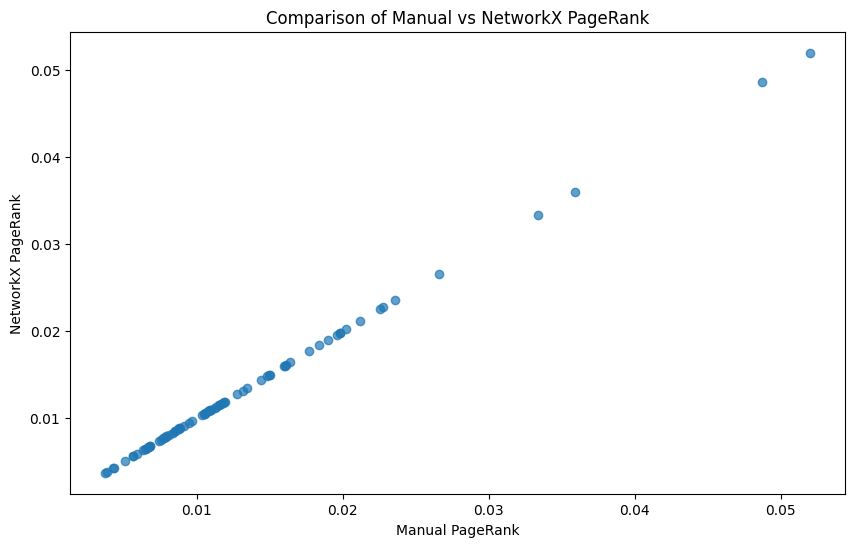

Pearson Correlation: 1.0000


In [79]:
# Convert your manually computed PageRank to Pandas DataFrame
manual_pagerank_df = pd.DataFrame(station_ranks, columns=["Station", "Manual_PageRank"])
# Merge manual and NetworkX PageRank results
comparison_df = manual_pagerank_df.merge(pagerank_df, on="Station", how="inner")
# Merge manual and NetworkX PageRank results
comparison_df = manual_pagerank_df.merge(pagerank_df, on="Station", how="inner")
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(comparison_df["Manual_PageRank"], comparison_df["PageRank"], alpha=0.7)
plt.xlabel("Manual PageRank")
plt.ylabel("NetworkX PageRank")
plt.title("Comparison of Manual vs NetworkX PageRank")
plt.show()


from scipy.stats import pearsonr

pearson_corr, _ = pearsonr(comparison_df["Manual_PageRank"], comparison_df["PageRank"])
print(f"Pearson Correlation: {pearson_corr:.4f}")

In [48]:
final_data.show(2)

+-------+-------------+-----------+---------------+----------+----------+-------------------+-------------------+-------------------+--------------------+-------------------+-----------------------------+------------------------------+-----------------------------+---------------------+------------------+----------+-----+--------------------+------------------+---------+-----------+----------------+------------------+----------------+---------+-----------+--------------+-----------------+-----------------+--------------------+-------------+-------------+----------+---------------+----------+-----------+---------+--------+---------+-------+
|Trip ID|Start Station|End Station|Subscriber Type|Start_date|  End_date|         Start_time|           End_time|Max Temperature (C)|Mean Temperature (C)|Min Temperature (C)|Max Sea Level Pressure (mmHg)|Mean Sea Level Pressure (mmHg)|Min Sea Level Pressure (mmHg)|Max Wind Speed (km/h)|Precipitation (mm)|CloudCover|  Zip|  Start_Station_Name|Start_St

How the ranking changes according to different months

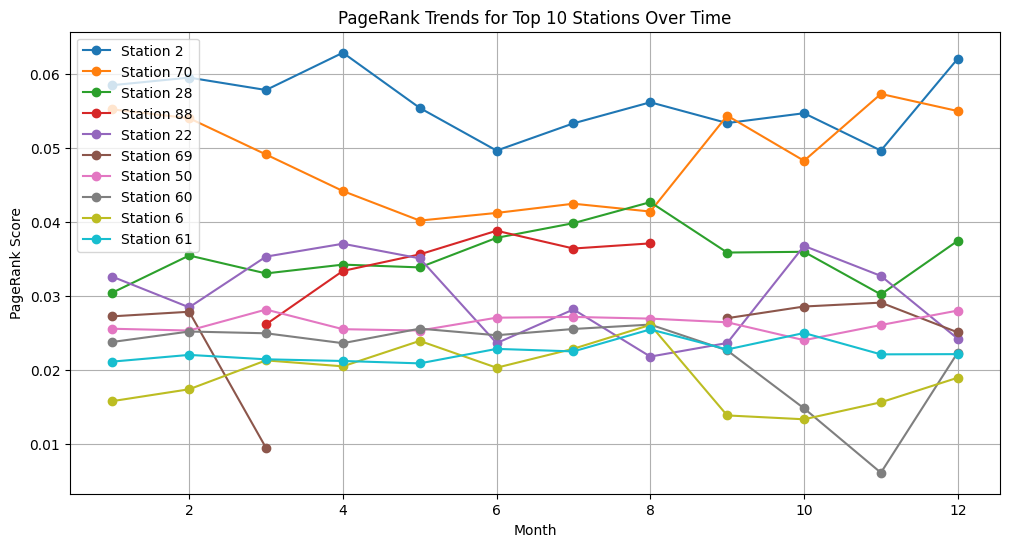

In [56]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas
edge_weights_pd = final_data.toPandas()

# Create an empty dictionary to store PageRank results for each month
monthly_pagerank = {}

# Iterate over each unique month in the dataset
for month in edge_weights_pd["Start_month"].unique():
    
    # Filter data for the specific month
    monthly_edges = edge_weights_pd[edge_weights_pd["Start_month"] == month]
    
    # Compute trip frequencies (weights)
    edge_counts = monthly_edges.groupby(["Start Station", "End Station"]).agg(weight=("Trip ID", "count")).reset_index()
    
    # Create a directed graph for the month
    G = nx.DiGraph()

    # Add weighted edges (trips between stations)
    for _, row in edge_counts.iterrows():
        G.add_edge(row["Start Station"], row["End Station"], weight=row["weight"])

    # Compute PageRank for the month
    pagerank_scores = nx.pagerank(G, alpha=0.85)

    # Convert to DataFrame and store the results
    pagerank_df = pd.DataFrame(list(pagerank_scores.items()), columns=["Station", "PageRank"])
    pagerank_df["Month"] = month
    monthly_pagerank[month] = pagerank_df

# Combine results into a single DataFrame
all_months_pagerank_df = pd.concat(monthly_pagerank.values(), ignore_index=True)

# Pivot the DataFrame to get months as rows and stations as columns
pivot_df = all_months_pagerank_df.pivot(index="Month", columns="Station", values="PageRank")

# Reset index for a clean format
pivot_df.reset_index(inplace=True)

# Plot PageRank trends for the most significant stations
plt.figure(figsize=(12, 6))
num_top_stations = 10  # Increase to top 10 stations

# Identify top stations by their highest PageRank in any month
top_stations = all_months_pagerank_df.groupby("Station")["PageRank"].max().sort_values(ascending=False).index[:num_top_stations]

for station in top_stations:
    if station in pivot_df.columns:
        plt.plot(pivot_df["Month"], pivot_df[station], marker='o', linestyle='-', label=f"Station {station}")

plt.xlabel("Month")
plt.ylabel("PageRank Score")
plt.title("PageRank Trends for Top 10 Stations Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [95]:
# Extract the top 15 most important stations
top_15_stations = pagerank_df["Station"].head(15).tolist()

# Display the result
print("Top 15 Most Important Stations:", top_15_stations)


Top 15 Most Important Stations: [2, 70, 22, 28, 50, 65, 61, 60, 74, 4, 77, 55, 88, 34, 35]


Columns in dataset: Index(['Trip ID', 'Start Station', 'End Station', 'Subscriber Type',
       'Start_date', 'End_date', 'Start_time', 'End_time',
       'Max Temperature (C)', 'Mean Temperature (C)', 'Min Temperature (C)',
       'Max Sea Level Pressure (mmHg)', 'Mean Sea Level Pressure (mmHg)',
       'Min Sea Level Pressure (mmHg)', 'Max Wind Speed (km/h)',
       'Precipitation (mm)', 'CloudCover', 'Zip', 'Start_Station_Name',
       'Start_Station_City', 'Start_Lat', 'Start_Long', 'Start_dock_count',
       'End_Station_Name', 'End_Station_City', 'End_Lat', 'End_Long',
       'End_dock_count', 'Rainfall Category', 'Start_weekday_num',
       'Start_weekday_mapped', 'Start_weekday', 'Trip_Duration', 'Start_hour',
       'Temperature Bin', 'Start_year', 'Start_month', 'Start_day', 'End_year',
       'End_month', 'End_day'],
      dtype='object')
Using 'Start_month' as the month column


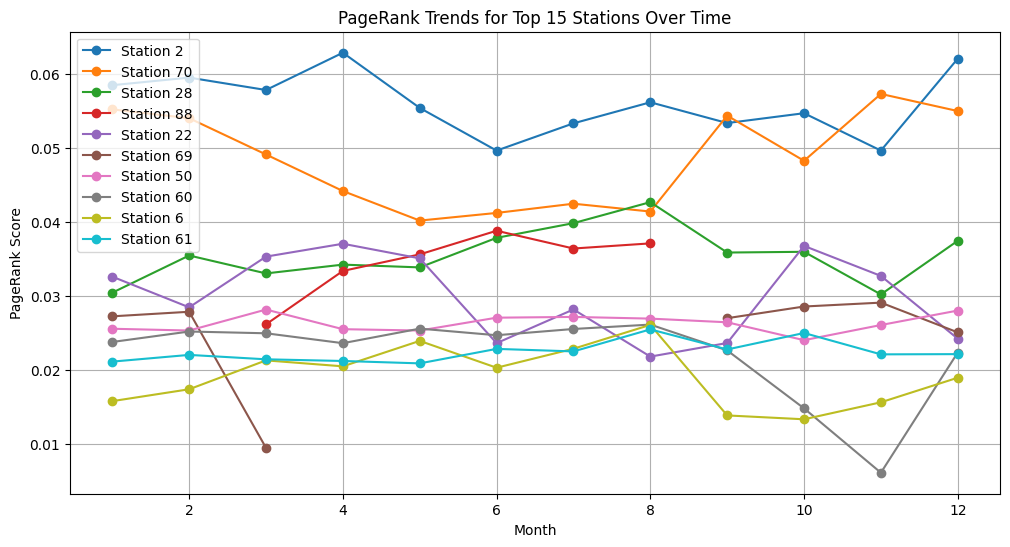

In [100]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas
edge_weights_pd = final_data.toPandas()

# Check available columns
print("Columns in dataset:", edge_weights_pd.columns)

# Attempt to find 'Start_month' with alternative names
possible_month_cols = [col for col in edge_weights_pd.columns if 'month' in col.lower()]
if not possible_month_cols:
    raise KeyError("Column related to 'Start_month' not found in dataset")

# Use the first matching column
start_month_col = possible_month_cols[0]
print(f"Using '{start_month_col}' as the month column")

# Create an empty dictionary to store PageRank results for each month
monthly_pagerank = {}

# Iterate over each unique month in the dataset
for month in edge_weights_pd[start_month_col].unique():
    
    # Filter data for the specific month
    monthly_edges = edge_weights_pd[edge_weights_pd[start_month_col] == month]
    
    # Compute trip frequencies (weights)
    edge_counts = monthly_edges.groupby(["Start Station", "End Station"]).agg(weight=("Trip ID", "count")).reset_index()
    
    # Create a directed graph for the month
    G = nx.DiGraph()

    # Add weighted edges (trips between stations)
    for _, row in edge_counts.iterrows():
        G.add_edge(row["Start Station"], row["End Station"], weight=row["weight"])

    # Compute PageRank for the month
    pagerank_scores = nx.pagerank(G, alpha=0.85)

    # Convert to DataFrame and store the results
    pagerank_df = pd.DataFrame(list(pagerank_scores.items()), columns=["Station", "PageRank"])
    pagerank_df["Month"] = month
    monthly_pagerank[month] = pagerank_df

# Combine results into a single DataFrame
all_months_pagerank_df = pd.concat(monthly_pagerank.values(), ignore_index=True)

# Pivot the DataFrame to get months as rows and stations as columns
pivot_df = all_months_pagerank_df.pivot(index="Month", columns="Station", values="PageRank")

# Reset index for a clean format
pivot_df.reset_index(inplace=True)

# Extract the top 15 most important stations
top_15_stations = all_months_pagerank_df.groupby("Station")["PageRank"].max().sort_values(ascending=False).index[:10].tolist()

# Plot PageRank trends for the top 15 stations
plt.figure(figsize=(12, 6))

for station in top_15_stations:
    if station in pivot_df.columns:
        plt.plot(pivot_df["Month"], pivot_df[station], marker='o', linestyle='-', label=f"Station {station}")

plt.xlabel("Month")
plt.ylabel("PageRank Score")
plt.title("PageRank Trends for Top 15 Stations Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [101]:
import pandas as pd

# Check if station 88 exists for all months
station_88_data = all_months_pagerank_df[all_months_pagerank_df["Station"] == 88]

# Display the missing months
missing_months = set(all_months_pagerank_df["Month"].unique()) - set(station_88_data["Month"].unique())

print("Station 88 data availability:")
print(station_88_data)

print("\nMissing months for Station 88:", missing_months)


Station 88 data availability:
     Station  PageRank  Month
68        88  0.037137      8
138       88  0.036444      7
208       88  0.038844      6
279       88  0.035652      5
348       88  0.033418      4
419       88  0.026208      3

Missing months for Station 88: {np.int32(1), np.int32(2), np.int32(9), np.int32(10), np.int32(11), np.int32(12)}


In [102]:
import pandas as pd

# Check if station 88 exists for all months
station_69_data = all_months_pagerank_df[all_months_pagerank_df["Station"] == 69]

# Display the missing months
missing_months = set(all_months_pagerank_df["Month"].unique()) - set(station_69_data["Month"].unique())

print("Station 69 data availability:")
print(station_69_data)

print("\nMissing months for Station 69:", missing_months)


Station 69 data availability:
     Station  PageRank  Month
410       69  0.009527      3
482       69  0.027905      2
554       69  0.027288      1
624       69  0.025121     12
693       69  0.029139     11
766       69  0.028613     10
835       69  0.027037      9

Missing months for Station 69: {np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8)}


Processing PageRank for Rainfall Category: No Rain
Processing PageRank for Rainfall Category: Rain


C:\Users\utente\AppData\Local\Temp\ipykernel_25072\861870821.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_top_stations).colors if num_top_stations <= 10 else plt.cm.get_cmap("tab20", num_top_stations).colors


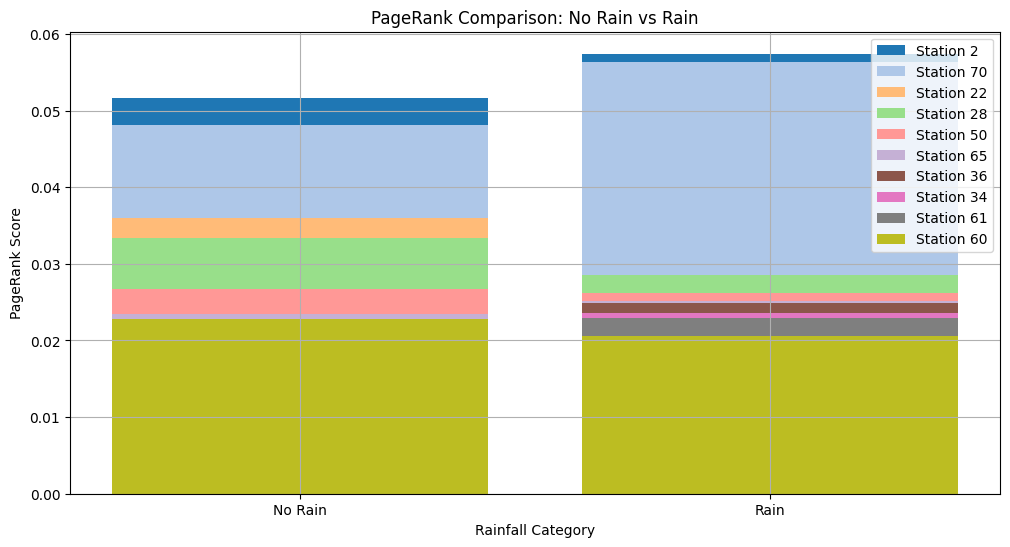

In [68]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col, when

# Categorize precipitation into two levels: "No Rain" and "Rain"
final_data = final_data.withColumn(
    "Rainfall Category",
    when(col("Precipitation (mm)") <= 0.1, "No Rain").otherwise("Rain")
)

# Convert PySpark DataFrame to Pandas
edge_weights_pd = final_data.toPandas()

# Create an empty dictionary to store PageRank results for each rainfall category
rain_pagerank = {}

# Iterate over each unique rain category in the dataset
for rain_category in edge_weights_pd["Rainfall Category"].unique():
    print(f"Processing PageRank for Rainfall Category: {rain_category}")

    # Filter data for the specific rainfall category
    category_edges = edge_weights_pd[edge_weights_pd["Rainfall Category"] == rain_category]
    
    # Compute trip frequencies (weights)
    edge_counts = category_edges.groupby(["Start Station", "End Station"]).agg(weight=("Trip ID", "count")).reset_index()
    
    # Create a directed graph for the rainfall category
    G = nx.DiGraph()

    # Add weighted edges (trips between stations)
    for _, row in edge_counts.iterrows():
        G.add_edge(row["Start Station"], row["End Station"], weight=row["weight"])

    # Compute PageRank for the rainfall category
    pagerank_scores = nx.pagerank(G, alpha=0.85)

    # Convert to DataFrame and store the results
    pagerank_df = pd.DataFrame(list(pagerank_scores.items()), columns=["Station", "PageRank"])
    pagerank_df["Rainfall Category"] = rain_category
    rain_pagerank[rain_category] = pagerank_df

# Combine results into a single DataFrame
all_rain_pagerank_df = pd.concat(rain_pagerank.values(), ignore_index=True)

# Pivot the DataFrame to get rainfall categories as rows and stations as columns
pivot_df = all_rain_pagerank_df.pivot(index="Rainfall Category", columns="Station", values="PageRank")

# Reset index for a clean format
pivot_df.reset_index(inplace=True)

# Define a list of distinct colors for better differentiation
colors = plt.cm.get_cmap("tab10", num_top_stations).colors if num_top_stations <= 10 else plt.cm.get_cmap("tab20", num_top_stations).colors

# Plot PageRank trends for the most significant stations
plt.figure(figsize=(12, 6))
num_top_stations = 10  # Increase to top 10 stations

# Identify top stations by their highest PageRank in any category
top_stations = all_rain_pagerank_df.groupby("Station")["PageRank"].max().sort_values(ascending=False).index[:num_top_stations]

for i, station in enumerate(top_stations):
    if station in pivot_df.columns:
        plt.bar(pivot_df["Rainfall Category"], pivot_df[station], label=f"Station {station}", color=colors[i % len(colors)])

plt.xlabel("Rainfall Category")
plt.ylabel("PageRank Score")
plt.title("PageRank Comparison: No Rain vs Rain")
plt.legend()
plt.grid(True)
plt.show()